# Detecting selective sweeps

In this exercise we are going to get our hands dirty lookinag at population genetic signatures of adaptation. When a beneficial mutation occurs, it may rapidly spread through the population, resulting in a selective sweep. We talked a bit about this process in lecture, and how it impacts patterns of genetic diversity in the area around the selected mutation. In this exercise, we will learn how to use a statistic called _iHS_ to try detect recent selective sweeps. We will start with an overview of the method, then apply it to simulated data to see how it works, and then finally take it out for a spin on some real genomic data from a human population.

## Part 0: Downloading a couple of files.

First we have to download a couple of files into your working directory. One file has genomic data for the final part of the exercise, and the other is just a figure that will help us understand the _iHS_ statistic. Run these commands to grab them

In [ ]:
!wget 'https://raw.githubusercontent.com/SchriderLab/selectionScanExercise/main/misc/ihs_fig.png'
!wget 'https://raw.githubusercontent.com/SchriderLab/selectionScanExercise/main/preCookedData/CEU50.chr2LCT.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz'

## Part 1: Understanding the integrated haplotype score (_iHS_)

In the lecture, we briefly talked about a few statistics used to summarize patterns of genetic variation. The _iHS_ statistic is a bit more complex than those in its formulation, but our goal here will be just to understand it conceptually. Let's start by taking a look at a figure from Voight et al. (2006), the paper that introduced _iHS_:

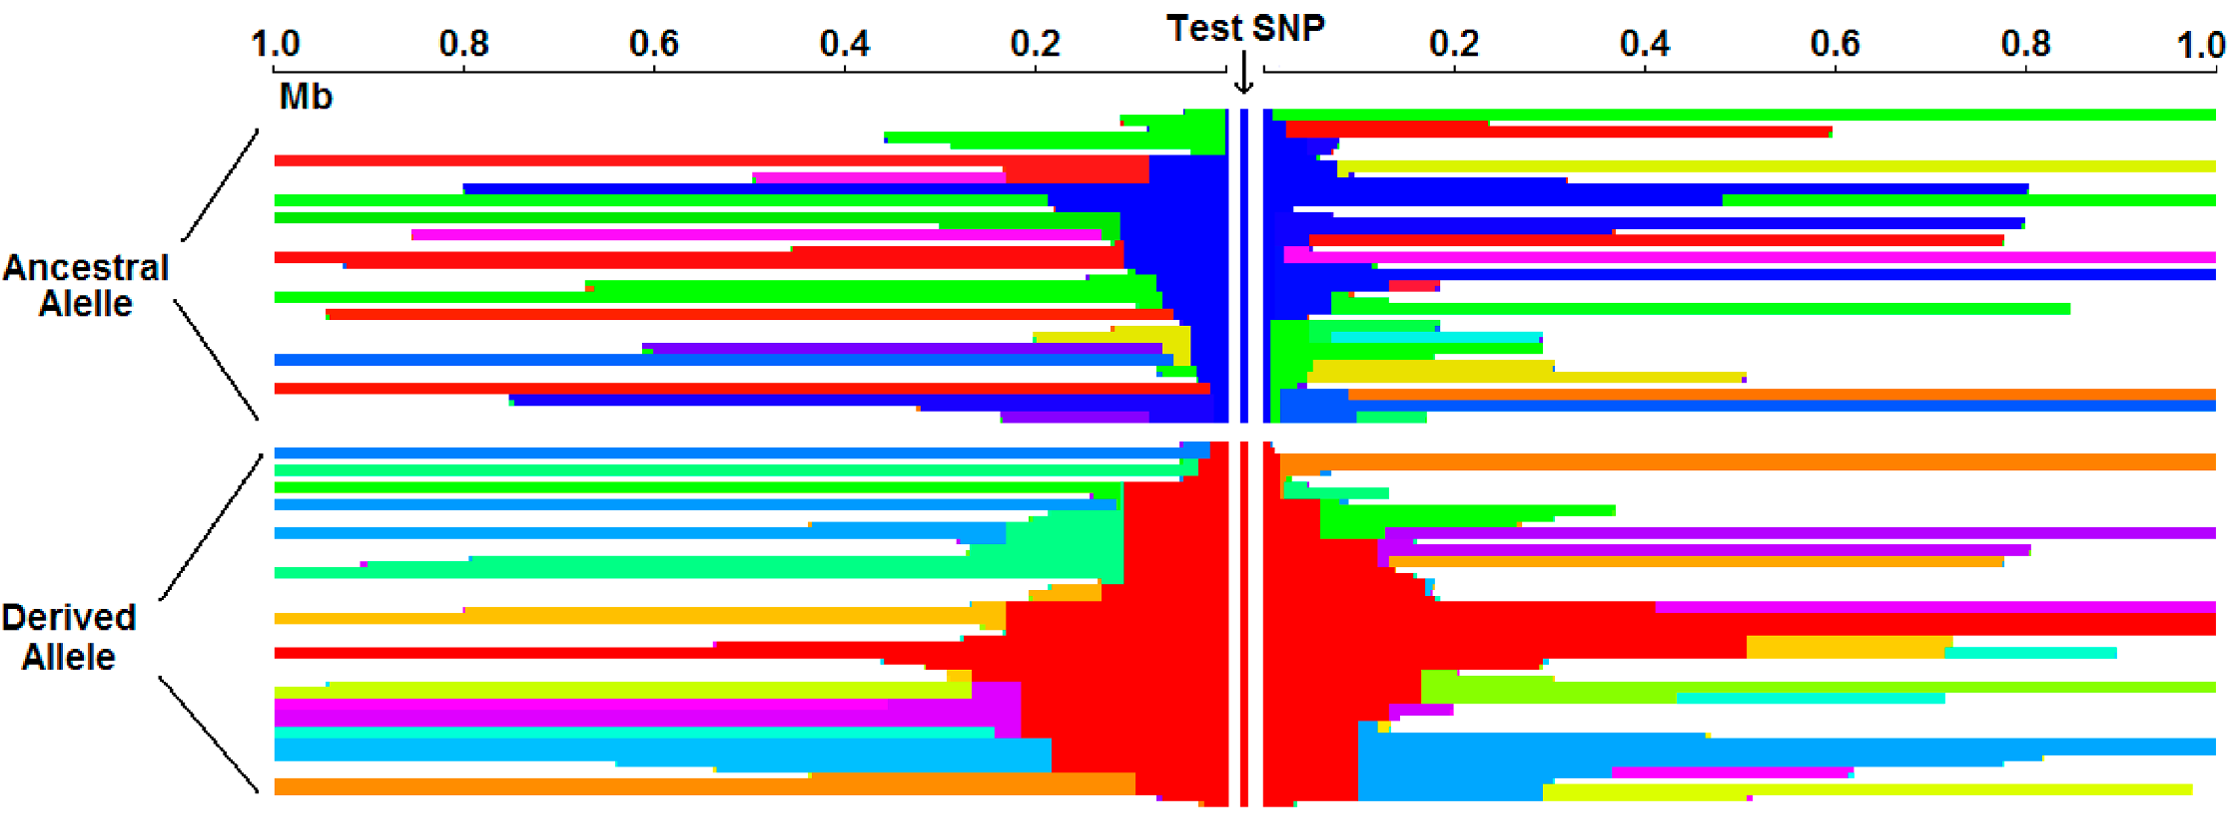

In [1]:
# We have to import the Image function to view an image file in this notebook
from IPython.display import Image

# Now we can display the figure, which should be present in your working directory.
Image('ihs_fig.png')

At first this looks like some bad abstract art, but we can make sense of it. It is really just a representation of a population genetic alignment: the _x_-axis shows different SNPs, and each haplotype is shown as a separate row on the _y_-axis. But instead of looking at "A"s, "C"s, "G"s, and "T"s, we are representing genotypes by colors. The color scheme will make sense if we start at the center: the Test SNP. This is the SNP that we are testing for evidence of positive selection. Has it rapidly increased in frequency (i.e. is it involved in an ongoing selective sweep) or not? At the Test SNP, we have two alleles, the ancestral allele and the derived allele, which we will color as blue and red, respectively.

First, let's focus on individuals with the ancestral allele (they are all colored blue at the Test SNP, and present in the top half of this figure), and let's move out to the right, looking at sites in the genome to the right of our Test SNP. At first, we see a column that is all blue--that is, all individuals with the ancestral/blue allele are our Test SNP are also identical to one another at these other sites to the right. However, we pretty quickly come to a point where some of our individuals are green. This is because we have reached a point where our individuals having the ancestral/blue allele at the Test SNP are no longer identical: at this site, there is a SNP where some of these individuals have the "green" allele, so we color them green, while most do not, and thus they remain blue. Note that the coloring here is arbitrary, green and blue could easily have been swapped with purple and orange or whatever, but the coloring has been done to simply highlight differences among individuals harboring the ancestral allele at our Test SNP. We press on, further to the right, and quickly find some more new colors popping up, representing more differences among individuals with the ancestral allele at the Test SNP. We see that as we move further and further away, we find more differences. This is because recombination and mutation events break up similarities among individuals, and the wider the genomic region you examine, the more opportunities for these events there have been.

Now, let's switch our focus to individuals with the derived allele (red). We again see that these individuals are all identical at the Test SNP, which must be the case by definition, and as we move further away we start to see some differences creep in. However, this takes a bit longer for the derived allele than it did for the ancestral allele: the genomic region where all or most of our individuals are colored red is larger than the size of the blue segment in the top half of the figure. This is because the derived allele is newer than the ancestral allele, so there hasn't been as much evolutionary time for new mutation and recombination events to introduce diversity into the subset of individuals that have the red allele. Moreover, this particular allele happens to be positively selected, and it has increased in frequency rather quickly, meaning we have had even less time for mutation and recombination events. We can see that there is a noticeable difference in the total size of the red portion of the bottom half of the plot and the total size of the blue portion in the top half of the plot, and this is a consequence of the rapid spread of the derived allele in this example. The magnitude of the difference between the red portion on the bottom plot and the blue portion on the top plot is in essence the information that _iHS_ is trying to capture. (This isn't exactly what _iHS_ measures, but that is enough of an explanation for now. If you want to see more detail on what exactly _iHS_ calculates, check out the paper: https://doi.org/10.1371/journal.pbio.0040072).

## Part 2: Characterizing the behavior of _iHS_ on simulated data

Before we start playing around with using _iHS_ to detect selection signatures in real genomic data, we need to be certain that the statistic behaves the way that it should. The best way to do this sort of testing in population genetics is to perform simulations. So we will do just that by using the simulator msprime (https://tskit.dev/msprime/docs/stable/intro.html).

### Simulated examples of neutral evolution

First we will see what _iHS_ values look like in the absence of natural selection. Let's start by importing some python modules that we will need throughout the exercise, including msprime:

In [ ]:
import msprime
import allel
import numpy as np
import matplotlib.pyplot as plt

Now that these tools have been imported we can get to work. Let's start by familiarizing ourselves with msprime. First up, we will simulate a 10 kilobase region, with a population of 10000 individuals, recominbation and mutation rates of 1e-8 (similar to rates measured in humans), and we will take a sample of 10 (haploid) individuals:

In [ ]:
ts = msprime.sim_ancestry(10, recombination_rate=1e-8, sequence_length=1e4, ploidy=1, population_size=10000)
mts = msprime.sim_mutations(ts, rate=1e-8)

That's it! Super easy. But notice how we use two commands here, the first one seems to be simulating the "ancestry" of our population sample, and the second one simulates mutations. What does that mean? Well, the first command simply simulates the evolutionary trees connecting the individuals in our sample. I say "trees" and not "tree" because recombination will cause there to be multiple trees along the sequence (crossover events cause different parts of the genome to have different evolutionary histories). The sim_ancestry function generates our "tree sequence" that contains this information.

Once we have generated these trees, then we can simply plop mutations down onto different branches the trees according to our specified rate. All descendants of the branch where a mutation occurred will posess that mutation, so it is easy to map these mutations onto individuals in our sample. The sim_mutations function does all of this for us.

Once this is done, we are going to want to put this information into a data structure that we can use. Specifically, we are going to be using the scikit-allel module (https://scikit-allel.readthedocs.io/en/stable/) to calculate _iHS_, so we will use allel's HaplotypeArray data structure to store our mutations properly. To do this, we simply need a matrix where the rows correspond to different variants and the columns correspond to each of the 10 individuals in our sample. The code below does all of this, while also printing some stuff out to help you see what is going on:

In [ ]:
hapArray = []
posArray = []
print("mutations occurring during simulation:")
print("position", "alleles at site", "genotypes", sep="\t")
for var in mts.variants():
    hapArray.append(var.genotypes)
    posArray.append(int(round(var.site.position)))
    print(int(var.site.position), var.alleles, var.genotypes, sep="\t")
print("")

# our haplotype array is now a list of lists, so we need to
# convert this into allel's HaplotypeArray using the
# HaplotypeArray() constructor method
hapArray = allel.HaplotypeArray(hapArray)

print("number of polymorphisms:", hapArray.n_variants)
print("number of individuals:", hapArray.n_haplotypes)
print("haplotype array:")
print(hapArray)

Easy! Now let's see what happens when we simulate a larger region:

In [ ]:
ts = msprime.sim_ancestry(100, recombination_rate=1e-8, sequence_length=5e6, ploidy=1, population_size=10000)
mts = msprime.sim_mutations(ts, rate=1e-8)

hapArray = []
posArray = []
for var in mts.variants():
    hapArray.append(var.genotypes)
    posArray.append(int(round(var.site.position)))


hapArray = allel.HaplotypeArray(hapArray)
print(hapArray.n_variants)
print(hapArray.n_haplotypes)

This region was 5 megabases in length. But msprime still simulated it in the blink of an eye!

Okay, our goal is to calculate _iHS_ scores, so maybe we should get to work on that:

In [ ]:
ihsScores = allel.ihs(hapArray, posArray)

Wait, that's all? This scikit-allel package really makes things easy!

Well, there is actually a bit of post-processing to do, but it is pretty painless. First, think about what happens when we want to calculate an _iHS_ score near the edge of a chromosome. We can try to look at the red and blue portions of our sample like in the figure above, but we will run over the edge of the chromosome before we get the chance to see any meaningful patterns. In these cases, scikit-allel's ihs function will simply return NaN values (Not a Number), so we might as well remove these from our data before we press on.

In [ ]:
# First, initialize some empty arrays that we will use to
# store the NaN-less versions of all the information we
# obtained above: not just the iHS scores, but also the
# haplotypes and the positions of polymorphisms in case
# we decide we want to use that information later.
ihsScoresNanless = []
hapArrayNanless = []
posArrayNanless = []

# iterate through all of our polymorphisms
for i in range(len(posArray)):
    # grab those who got an iHS score that wasn't a NaN
    if not np.isnan(ihsScores[i]):
        # populate our ihs, position, and haplotype arrays
        # with values corresponding to these non-NaN scores
        ihsScoresNanless.append(ihsScores[i])
        posArrayNanless.append(posArray[i])
        hapArrayNanless.append(hapArray[i])

# convert our array of haplotypes into a proper HaplotypeArray
hapArrayNanless = allel.HaplotypeArray(hapArrayNanless)

# Let's see how many polymorphisms we filtered out
print(hapArrayNanless.n_variants)
# The number of individuals in our sample is unchanged
print(hapArrayNanless.n_haplotypes)

Looks like most of our _iHS_ scores were actually nans! Thsi is because we simulated a fairly small chromosome (5 Mb is pretty tiny in the grand scheme of things). But, let's take a look at the distribution of values we got buy plotting a histogram using the matplotlib module we imported earlier:

In [ ]:
plt.hist(ihsScoresNanless, bins=20)
plt.ylabel('iHS score')
plt.show()

Cool! But notice that our distribution is kind of skewed here. This actually a symptom of a potentially bigger problem: _iHS_ scores will be somewhat dependent on allele frequencies: much rarer, newer alleles will be associated with much less diversity than somewhat older, more common alleles. We can account for this by standardizing our data by alleles frequency. The way this works is that we partition our _iHS_ scores according to the frequency of the derived allele at the target SNP, and then standardize within each bin (i.e. the values within each bin are convered into z-scores: https://en.wikipedia.org/wiki/Standard_score).

Let's do this, and see how it affects our histogram:

In [ ]:
dac = hapArrayNanless.count_alleles()[:,1]
ihsScoresStd, stdBins = allel.standardize_by_allele_count(ihsScoresNanless, dac, n_bins=20, diagnostics=False)

plt.hist(ihsScoresStd, bins=20)
plt.ylabel('iHS score')
plt.show()

This looks a lot better. Maybe still a little noisy beause it is based on a relatively small number of polymorphisms, but we will be looking at much bigger datasets in a bit!

### Calculting _iHS_ on simulated selective sweeps

That was fun (for me anyway), but our goal is to use _iHS_ to find sweeps. So we really ought to simulate a selective sweep and see what happens. msprime can also do this. We simply have to add the "model" information in the following block of code:

In [ ]:
L=1e8 # We are increasing our chromosome length here to compensate for the loss of diversity caused by the sweep.
N=10000

# define our hard sweep model
sweep_model = msprime.SweepGenicSelection(
    position=L / 2,  # beneficial mutation location: middle of chrom
    start_frequency=1.0 / (2 * N), # starting frequency of the sweeping mutation
    end_frequency=0.9, # final frequency of the mutation (incomplete sweep)
    s=0.25, # selection coefficient of the beneficial mutation
    dt=1e-6, # nevermind this!
)

ts = msprime.sim_ancestry(
    100,
    model=[sweep_model, msprime.StandardCoalescent()],
    population_size=N,
    recombination_rate=1e-8,
    sequence_length=L,
    ploidy=1,
)

mts = msprime.sim_mutations(ts, rate=1e-8)

So we had to set a few additional parameters related to the sweep: the location of the sweeping mutation, the starting frequency, the frequency at the time of sampling, and the selective advantage (a pretty whopping 25% fitness boost in this case). Then we just ran our simulation as normal. Pretty easy!

Now let's process our results in the same manner as for our neutral simulations, and check out the histogram:

In [ ]:
hapArraySel = []
posArraySel = []
for var in mts.variants():
    hapArraySel.append(var.genotypes)
    posArraySel.append(int(round(var.site.position)))


hapArraySel = allel.HaplotypeArray(hapArraySel)
print(hapArraySel.n_variants)
print(hapArraySel.n_haplotypes)
ihsScoresSel = allel.ihs(hapArraySel, posArraySel)


ihsScoresSelNanless = []
hapArraySelNanless = []
posArraySelNanless = []
for i in range(len(posArraySel)):
    if not np.isnan(ihsScoresSel[i]):
        ihsScoresSelNanless.append(ihsScoresSel[i])
        posArraySelNanless.append(posArraySel[i])
        hapArraySelNanless.append(hapArraySel[i])

hapArraySelNanless = allel.HaplotypeArray(hapArraySelNanless)

print(hapArraySelNanless.n_variants)
print(hapArraySelNanless.n_haplotypes)

plt.hist(ihsScoresSelNanless, bins=20)
plt.ylabel('iHS score')
plt.show()

Well that looks different! If you scroll back up and compare to the distribution of our (unstandardized) _iHS_ values from our neutral simulation, you can clearly see that we have a lot more extreme values here. But again, we should standardize by allele frequency:

In [ ]:
dac = hapArraySelNanless.count_alleles()[:,1]
ihsScoresStdSel, stdBinsSel = allel.standardize_by_allele_count(ihsScoresSelNanless, dac, n_bins=20, diagnostics=False)

plt.hist(ihsScoresStdSel, bins=20)
plt.ylabel('iHS score')
plt.show()

That is less crazy, but still it looks like we have an excess of extreme values (fatter tails) compared to our neutral example. Those values were probably calculated at SNPs in the vicinity of the sweep, where we have some "long range haplotypes" just like our red example in the figure we looked at earlier. This is probably a sufficent sanity check that our calculations are working as expected. Woohoo! Now let's take a look at...

### A more complicated/realistic demographic model

One commonly used model of demographic changes over the course of human history is Gutenkunst et al.'s (2009; https://doi.org/10.1371/journal.pgen.1000695) model of the Out-of-Africa migration. This model contains three populations, an African population (abbreviated AFR below), a population of Han-Chinese individuals from Beijing (CHB), and a population of individuals of European ancestry from Utah (abbreviated CEU, with the C itself standing for another abbreviation, CEPH, which stands for Centre d′Etudes du Polymorphisme Humain, which created the dataset that this simulated subpopulation is based on. Ugh.).

This model has a lot of moving parts, but thankfully it has all been nicely implemented for us in the msprime documentation, so we can borrow it from there without worrying about making any errors. The code below was taken from https://tskit.dev/msprime/docs/stable/demography.html#sec-demography-examples-population-tree.

We looked at this model in the population genetics lectures. Briefly, it begins with an ancestral African population of 7300 individuals. Then, 220,000 years ago (assuming a generation time of 25 years), this population expands to 12,300 individuals---this change is noted to correspond roughly with the emergence of anatomically modern humans, but really this fact has no bearing on the model or the resulting simulations (only genomes are simulated---no phenotypes!). Later, the African population splits into two subpopulations (African and Eurasian) 140,000 years ago, with the initial size of the Eurasian population being 2,100 individuals. Much later, the Eurasian population itself splits into two subpopulations 21.2 thousand years ago, with the initial sizes of the resulting Asian and European populations being 510 and 1,000 individuals, respectively. These two subpopulations then experience expontential growth at rates of 0.4% and 0.55% per year, respectively, until the present day. The final sizes of the Asian and European populations are thus roughly 54,090 and 29,725 individuals, while the African population in this model has remained constant at 12,300 years. The model also includes migration between these subpopulations.

The code below creates this demographic model, and the table at the bottom summarizes it. One weird thing that you might notice about the table and code if you look closely is that it seems to be backwards. For example, the initial_size of CEU is 29725, when really that is the size at the present-day. This is because msprime is a coalescent simulator, which means that it simulates these individuals backwards in time until they "coalesce" into their most recent common ancestor, giving us a tree (or a tree sequence, when recombination occurs). Kinda weird, but this simulation approach is extremely fast. You can read more about msprime here: https://doi.org/10.1371/journal.pcbi.1004842.

In [ ]:
import math

# Times are provided in years, so we convert into generations.
generation_time = 25
T_OOA = 21.2e3 / generation_time
T_AMH = 140e3 / generation_time
T_ANC = 220e3 / generation_time
# We need to work out the starting population sizes based on
# the growth rates provided for these two populations
r_CEU = 0.004
r_CHB = 0.0055
N_CEU = 1000 / math.exp(-r_CEU * T_OOA)
N_CHB = 510 / math.exp(-r_CHB * T_OOA)
N_AFR = 12300

demography = msprime.Demography()
demography.add_population(
    name="YRI",
    description="Yoruba in Ibadan, Nigeria",
    initial_size=N_AFR,
)
demography.add_population(
    name="CEU",
    description=(
        "Utah Residents (CEPH) with Northern and Western European Ancestry"
    ),
    initial_size=N_CEU,
    growth_rate=r_CEU,
)
demography.add_population(
    name="CHB",
    description="Han Chinese in Beijing, China",
    initial_size=N_CHB,
    growth_rate=r_CHB,
)
demography.add_population(
    name="OOA",
    description="Bottleneck out-of-Africa population",
    initial_size=2100,
)
demography.add_population(
    name="AMH", description="Anatomically modern humans", initial_size=N_AFR
)
demography.add_population(
    name="ANC",
    description="Ancestral equilibrium population",
    initial_size=7300,
)

# Set the migration rates between extant populations
demography.set_symmetric_migration_rate(["CEU", "CHB"], 9.6e-5)
demography.set_symmetric_migration_rate(["YRI", "CHB"], 1.9e-5)
demography.set_symmetric_migration_rate(["YRI", "CEU"], 3e-5)

# Join the extant populations into ancestral populations (adjusting migration accordingly)
demography.add_population_split(time=T_OOA, derived=["CEU", "CHB"], ancestral="OOA")
demography.add_symmetric_migration_rate_change(
    time=T_OOA, populations=["YRI", "OOA"], rate=25e-5
)
demography.add_population_split(time=T_AMH, derived=["YRI", "OOA"], ancestral="AMH")
demography.add_population_split(time=T_ANC, derived=["AMH"], ancestral="ANC")

demography

Now that we have our demographic model, we are ready to simulate. We are going to sample from the CEU population, with a sample size of 50 (25 diploids), matching the subset of the 1000 Genomes Data that we will be playing with in the final section. Otherwise, these steps will look very familiar. First we run the simulation and make our HaplotypeArray:

In [ ]:
nCEU = 50
ts = msprime.sim_ancestry(
    [msprime.SampleSet(nCEU, "CEU")],
    demography=demography,
    sequence_length=5e6,
    recombination_rate=1e-8,
    ploidy=1)

mts = msprime.sim_mutations(ts, rate=1e-8)

hapArray = []
posArray = []
for variant in mts.variants():
    hapArray.append(variant.genotypes)
    posArray.append(int(round(variant.site.position)))

hapArray = allel.HaplotypeArray(hapArray)
print(hapArray.shape)

Then we remove our NaNs and plot our histogram:

In [ ]:
ihsScores = list(allel.ihs(hapArray, posArray))
print(len(ihsScores))

ihsScoresNanless= []
hapArrayNanless = []
posArrayNanless = []

for i in range(len(posArray)):
    if not np.isnan(ihsScores[i]):
        ihsScoresNanless.append(ihsScores[i])
        posArrayNanless.append(posArray[i])
        hapArrayNanless.append(hapArray[i])

hapArrayNanless = allel.HaplotypeArray(hapArrayNanless)
print(len(ihsScoresNanless))

plt.hist(ihsScoresNanless, bins=20)
plt.ylabel('iHS score')
plt.show()

This looks a bit different than our original (unstandardized histogram), so maybe the different demographic history had an effect here. Again, we will standardize and plot the histrogra:

In [ ]:
dac = hapArrayNanless.count_alleles()[:,1]
ihsScoresStdNanless, stdBinsNanless = allel.standardize_by_allele_count(ihsScoresNanless, dac, n_bins=20, diagnostics=False)

plt.hist(ihsScoresStdNanless, bins=20)
plt.ylabel('iHS score')
plt.show()

That looks a lot better. So standardizing will necessarily make the overall distribution fairly robust to demographic changes. The goal is then to look for outliers from this distribution, and see what we can learn about recent adaptation. So let's get our hands dirty and see if we can...

## Part 3: Detect signatures selection human population genetic data

The time has come to look at some actual genomic data. There should be some in your working directory, specifically, a compressed VCF file called CEU50.chr2LCT.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz. You can read about VCF (variant call format) files here (https://samtools.github.io/hts-specs/VCFv4.2.pdf), and learning this format is essential if you plan on doing population genetic work of any kind in the future, but it is not actually necessary to know to much about it to complete this exercise. That's because scikit-allel can read VCFs for us quite nicely:

In [ ]:
# read vcf
callset = allel.read_vcf('CEU50.chr2LCT.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz')
print(sorted(callset.keys()))

There are quite a few entires in this "callset" dictionary, but there are only two that we need 'variants/POS', which is basically our positions array (we will finally actually be using this information below), and 'calldata/GT', which is easily convertable to an instance of scikit-allel's GenotypeArray object. GenotypeArrays are different from HaplotypeArrays in that in the former each variant has one two-dimensional entry for each individual, with one dimension for each allele of our diploid individual (GenotypeArrays can also be extended to higher ploidy levels). HaplotypeArrays, on the other hand, have separate entries for each chromosomal copy in each individual. This will hopefully make more sense in a moment after the next two coding steps.

If our GenotypeArrays are from 'phased' individuals, then we can readily concert from one to the other and back again. So let's read in our GenotypeArray and convert it to a HaplotypeArray so we can plug it into our ihs function:

In [ ]:
posArrayCEU = callset['variants/POS']
print(posArrayCEU.shape)

gt = allel.GenotypeArray(callset['calldata/GT'])
print(gt.shape)

hapArrayCEU = gt.to_haplotypes(copy=True)
print(hapArrayCEU.shape)

Compare the shapes of the GenotypeArray and HaplotypeArray here and it should make some sense, but let's take a closer look a chunk of 30 SNPs (SNPs 20 through 49, 0-based and inclusive), and our diploid individual at index 12 (the 13th individual in our GenotypeArray), and compare this to our corresponding part of the HaplotpyeArray:

In [ ]:
print([list(x) for x in gt[20:50,12]])
print(hapArrayCEU[20:50,24])
print(hapArrayCEU[20:50,25])

The first line that we printed out shows the diploid genotypes for individual 12 at each of these 50 SNPs, and 0 and 1 correspond to the reference and alternate alleles (i.e. the allele in the human reference genome, and some other allele), respectively. So we see that this individual is homozygous for the alternate allele at the first of these SNPs for the, and heterozygous at the second to last SNP, with the first haplotpye having the alternate allele, and the second copy having the refernce allele. When we go and look at the corresponding haplotypes from our HaplotypeArray (haplotypes 24 and 25), we see this exact same pattern. So we can see that the phase information that was present in the GenotypeArray was carried over to our HaplotypeArray.

Warning: GenotypeArrays can also be used with unphased data, so if you convert those to HaplotypeArrays you will get scrambled haplotypes that don't really mean anything. Be advised!

Okay, let's calculate iHS, and plot some histograms. This will again all look very familliar:

In [ ]:
# calculate iHS scores
ihsScoresCEU = list(allel.ihs(hapArrayCEU, posArrayCEU))
print(len(ihsScoresCEU))

# remove nans
ihsScoresCEUNanless = []
hapArrayCEUNanless = []
posArrayCEUNanless = []

for i in range(len(posArrayCEU)):
    if not np.isnan(ihsScoresCEU[i]):
        ihsScoresCEUNanless.append(ihsScoresCEU[i])
        posArrayCEUNanless.append(posArrayCEU[i])
        hapArrayCEUNanless.append(hapArrayCEU[i])

hapArrayCEUNanless = allel.HaplotypeArray(hapArrayCEUNanless)
dacCEU = hapArrayCEUNanless.count_alleles()[:,1]
print(len(ihsScoresCEUNanless))

plt.hist(ihsScoresCEUNanless, bins=20)
plt.ylabel('iHS score')
plt.show()

ihsScoresCEUStdNanless, stdBins = allel.standardize_by_allele_count(ihsScoresCEUNanless, dacCEU, n_bins=20, diagnostics=False)

plt.hist(ihsScoresCEUStdNanless, bins=20)
plt.ylabel('iHS score')
plt.show()

It looks like we might have some extreme values here, but to try to make sense of what is going on it would be best to see where these extreme _iHS_ scores are located on the chromosome. We will do this by looking for 50 kilobase windows that have a large fraction of extreme _iHS_ scores. This is motivated by Voight et al.'s finding that in the presence of sweeps, extreme scores tend to be clustered, but that this is not expected under neutrality.

So, let's do it:

In [ ]:
wins = {}
winSize=50000

# loop through all SNPs in our dataset
for i in range(len(posArrayCEUNanless)):
    pos = posArrayCEUNanless[i]
    ihsScore = ihsScoresCEUStdNanless[i]
    
    # figureout with 50 kb window this SNP belongs to
    winIndex = int(pos // winSize)
    
    # if this window has not been visited yet, initialize it
    if not winIndex in wins:
        wins[winIndex] = []
    
    # add the ihs score to the list of values for this window
    wins[winIndex].append(abs(ihsScore))

winAvgs = {}
for winIndex in wins:
    
    # get all scores in this window with |ihs| > 2 (5% tails on either side)
    extremeValsInWin = [1 for x in wins[winIndex] if x > 2]
    
    # calculate the fraction of all ihs scores in this window that are extreme
    winAvgs[winIndex] = len(extremeValsInWin)/len(wins[winIndex])

print("track type=bedGraph name=ihsOutliers")
for winIndex in sorted(winAvgs):
    start = winIndex*winSize
    print("chr2", start, start+winSize, winAvgs[winIndex], sep="\t")

### Browsing our results

Okay, how can we visualize this stuff? The simplest way is to go to the UCSC Genome Browser. First, try this link: https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg19&position=chr2%3A134000000-140000000

Then, find the button that says "add custom tracks" and click it.

You will see two text boxes that you can enter data into. You can ignore the bottom one. In the top one (labeled "Paste URLs or data:"), copy the large list of results from our previous step--be sure to get everything!

Then click submit. and finally, click the UCSC link I shared jsut a few sentences above one last time. Let's chat about what you found!